In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("whitegrid", {"grid.color": ".2", "grid.linestyle": ":"})
sns.set(rc={'axes.labelsize': 15, 'ytick.labelsize': 14, 'xtick.labelsize': 15, 'axes.titlesize':18})

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

## Basic Exploration

In [2]:
df = pd.read_csv('../input/paddy-disease-classification/train.csv')
sub = pd.read_csv('../input/paddy-disease-classification/sample_submission.csv')

df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [3]:
#variety-wise diseases
df.groupby(['variety','label']).image_id.count().unstack().T

variety,ADT45,AndraPonni,AtchayaPonni,IR20,KarnatakaPonni,Onthanel,Ponni,RR,Surya,Zonal
label,,,,,,,,,,
bacterial_leaf_blight,406.0,NaN,NaN,10.0,10.0,4.0,34.0,NaN,2.0,13.0
bacterial_leaf_streak,107.0,NaN,NaN,NaN,35.0,69.0,NaN,NaN,NaN,169.0
bacterial_panicle_blight,260.0,14.0,NaN,NaN,NaN,NaN,63.0,NaN,NaN,NaN
blast,793.0,112.0,27.0,22.0,533.0,25.0,136.0,NaN,7.0,83.0
brown_spot,835.0,NaN,NaN,NaN,110.0,NaN,14.0,NaN,NaN,6.0
dead_heart,979.0,70.0,NaN,82.0,113.0,110.0,63.0,18.0,NaN,7.0
downy_mildew,331.0,NaN,55.0,NaN,121.0,40.0,6.0,NaN,20.0,47.0
hispa,833.0,181.0,340.0,NaN,66.0,81.0,32.0,NaN,NaN,61.0
normal,1457.0,NaN,NaN,NaN,NaN,8.0,281.0,18.0,NaN,NaN


In [4]:
# Defining the path for train and test images
train_dir = pathlib.Path("../input/paddy-disease-classification/train_images")
test_dir = pathlib.Path('../input/paddy-disease-classification/test_images')

In [5]:
#class names
class_names = os.listdir('../input/paddy-disease-classification/train_images')

In [6]:
DIR = str(train_dir)

cl = [] #class list
cd = [] #class size list

for i in class_names:
    cl.append(i)
    cd.append(len(os.listdir(DIR + '/' + i)))

class_dist = pd.DataFrame({'Class':cl, 'Size':cd})
class_dist.sort_values(by = 'Size', ascending = False)

,Class,Size
7,normal,1764
6,blast,1738
1,hispa,1594
8,dead_heart,1442
0,tungro,1088
5,brown_spot,965
2,downy_mildew,620
4,bacterial_leaf_blight,479
3,bacterial_leaf_streak,380
9,bacterial_panicle_blight,337


In [7]:
image_count_train = len(list(train_dir.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_dir.glob('*.jpg')))
print(image_count_test)

10407
3469


### Visualizing some Sample Images

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'tungro'),
  Text(1, 0, 'hispa'),
  Text(2, 0, 'downy_mildew'),
  Text(3, 0, 'bacterial_leaf_streak'),
  Text(4, 0, 'bacterial_leaf_blight'),
  Text(5, 0, 'brown_spot'),
  Text(6, 0, 'blast'),
  Text(7, 0, 'normal'),
  Text(8, 0, 'dead_heart'),
  Text(9, 0, 'bacterial_panicle_blight')])

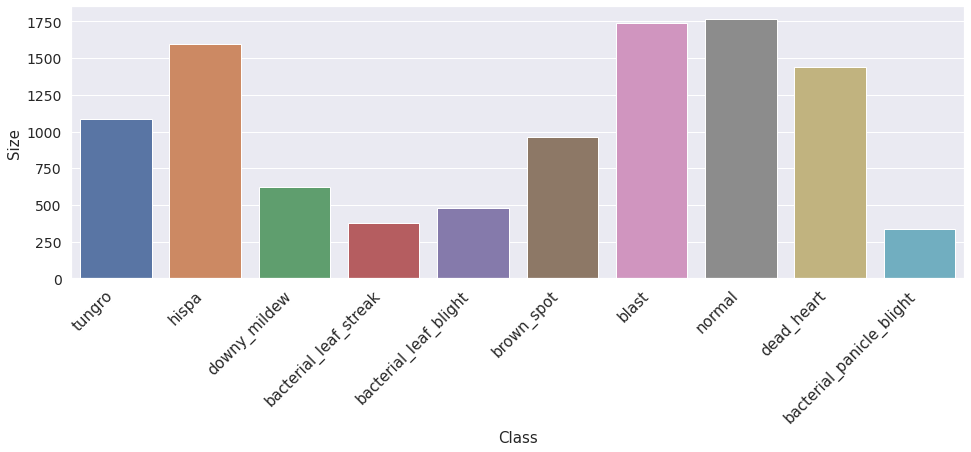

In [8]:
plt.figure(figsize = [16,5])
sns.barplot(class_dist['Class'], class_dist['Size'])
plt.xticks(rotation = 45, ha = 'right')

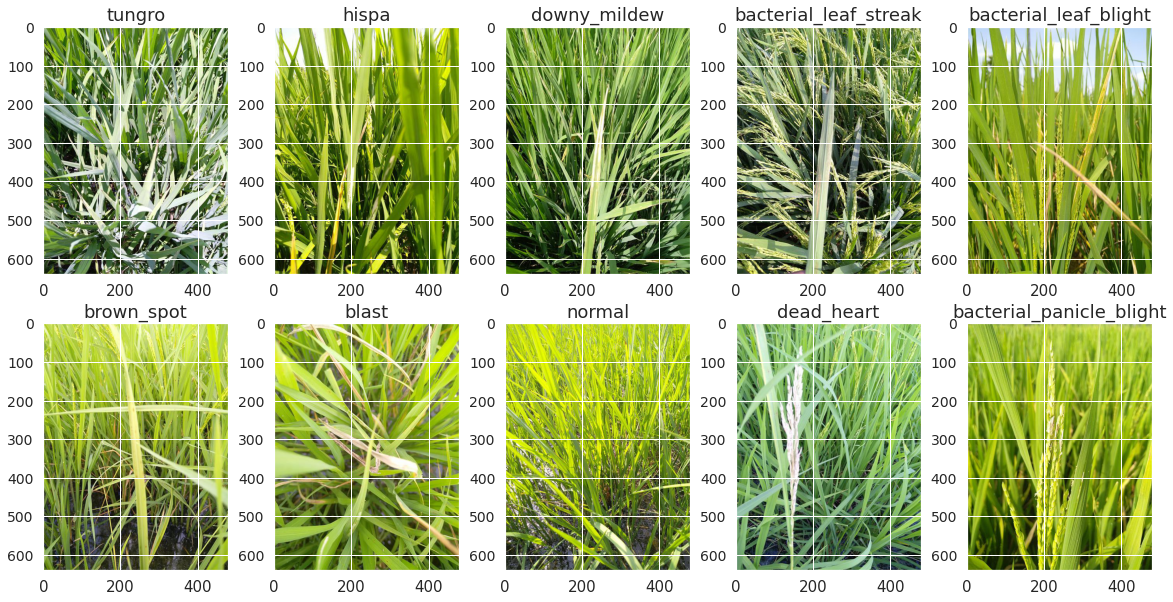

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
for i in range(10): 
  plt.subplot(2, 5, i + 1)
  image = plt.imread(str(list(train_dir.glob(class_names[i]+'/*.jpg'))[0]))
  plt.title(class_names[i])
  plt.imshow(image)

In [10]:
image.shape

(640, 480, 3)

## Data Augmentation

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
from skimage.transform import rescale
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    validation_split=0.1,
    rotation_range=30,
    shear_range=0.25,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
)

In [13]:
train_gen = datagen.flow_from_directory(
    train_dir,
    subset="training",
    seed=42,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 9371 images belonging to 10 classes.


In [14]:
valid_gen = datagen.flow_from_directory(
    train_dir,
    subset="validation",
    seed=42,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 1036 images belonging to 10 classes.


In [15]:
print(train_gen.class_indices, '\n')
print(len(train_gen.class_indices))
N_CLASS = len(train_gen.class_indices)

{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9} 

10


## Model Building

In [16]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.regularizers import l2
num_classes = 10

model = Sequential([layers.experimental.preprocessing.Rescaling(1./1., input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, kernel_regularizer = l2(0.001), activation='relu'))

model.add(Dense(num_classes, activation = "softmax"))

2022-08-30 11:41:08.900467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 11:41:09.038680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 11:41:09.039640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 11:41:09.041490: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 64)        1

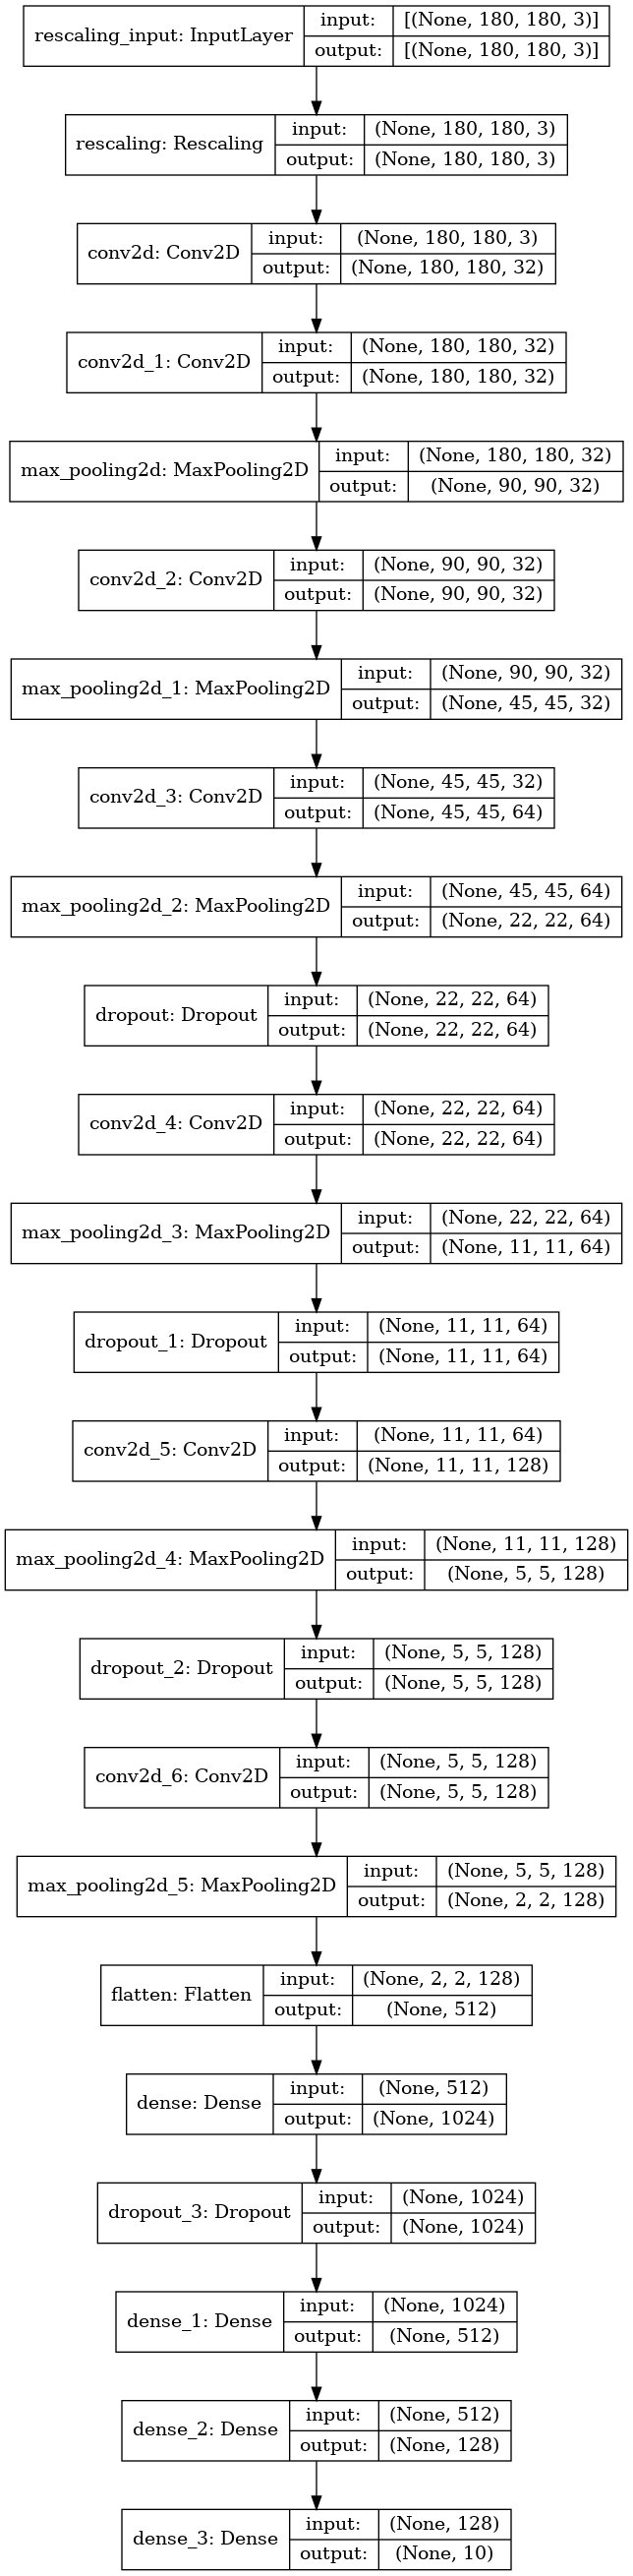

In [17]:
model.summary()
keras.utils.plot_model(model, to_file='model.png',expand_nested=True,show_shapes=True)

### Leaning Rate and Early Stopping

In [18]:
#callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=0.00001, patience=10, mode='auto', verbose=0, restore_best_weights=True)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, min_lr=0.00001, patience=3)

callbacks = [early_stopping_callback, lr_reducer]

In [19]:
tf.test.is_gpu_available()
#tf.test.gpu_device_name()

2022-08-30 11:41:13.236969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 11:41:13.237616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 11:41:13.238021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 11:41:13.238464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 11:41:13.238819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

True

In [20]:
optimizer = "adam" #'RMSprop'
loss = tf.keras.losses.CategoricalCrossentropy()#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

epochs = 200
## Your code goes here, use 50 epochs.
history_model = model.fit(
                    train_gen,
                    validation_data=valid_gen,
                    epochs=epochs,
                    callbacks=callbacks
)

2022-08-30 11:41:14.132952: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-08-30 11:41:16.392776: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


293/293 [==============================] - 176s 572ms/step - loss: 2.2262 - accuracy: 0.1685 - val_loss: 2.1753 - val_accuracy: 0.1670
Epoch 2/200
293/293 [==============================] - 133s 452ms/step - loss: 2.0438 - accuracy: 0.2673 - val_loss: 2.0401 - val_accuracy: 0.2780
Epoch 3/200
293/293 [==============================] - 132s 451ms/step - loss: 1.8074 - accuracy: 0.3738 - val_loss: 1.7083 - val_accuracy: 0.4073
Epoch 4/200
293/293 [==============================] - 133s 453ms/step - loss: 1.7212 - accuracy: 0.4081 - val_loss: 1.6537 - val_accuracy: 0.4353
Epoch 5/200
293/293 [==============================] - 132s 450ms/step - loss: 1.6525 - accuracy: 0.4353 - val_loss: 1.6002 - val_accuracy: 0.4247
Epoch 6/200
293/293 [==============================] - 132s 450ms/step - loss: 1.5848 - accuracy: 0.4554 - val_loss: 1.5133 - val_accuracy: 0.4788
Epoch 7/200
293/293 [==============================] - 133s 456ms/step - loss: 1.5418 - accuracy: 0.4660 - val_loss: 1.5481 - val_

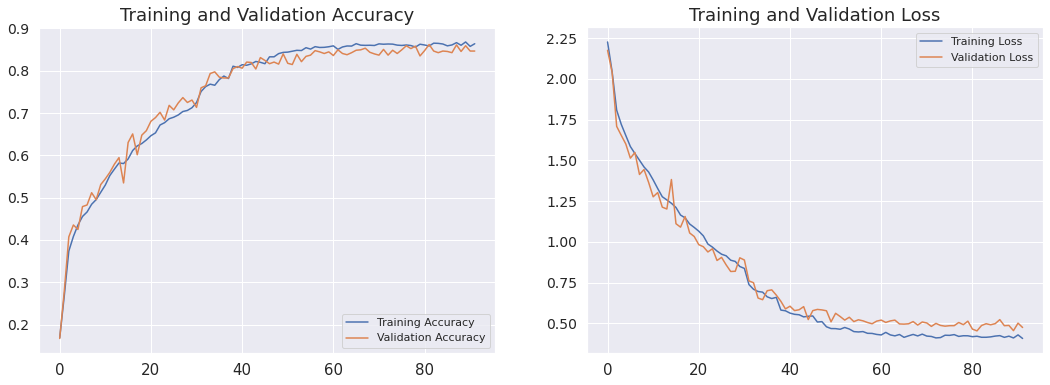

In [21]:
acc = history_model.history['accuracy']
val_acc = history_model.history['val_accuracy']

loss = history_model.history['loss']
val_loss = history_model.history['val_loss']

epochs_range = history_model.epoch

plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
#save model
#!mkdir -p saved_model
#model.save('saved_model/paddy_model0.h5')

#load_model
#load_model = tf.keras.models.load_model('saved_model/paddy_model0.h5')

In [23]:
test_loc = '../input/paddy-disease-classification/test_images'
test_data = ImageDataGenerator(rescale=1.0/255).flow_from_directory(    
    directory=test_loc,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes=['.'],
    shuffle=False,
)

Found 3469 images belonging to 1 classes.


In [24]:
y_predict_max = np.argmax(model.predict(test_data, verbose=1),axis=1)

109/109 [==============================] - 39s 360ms/step


In [25]:
inverse_map = {v:k for k,v in train_gen.class_indices.items()}

predictions = [inverse_map[k] for k in y_predict_max]

In [26]:
files=test_data.filenames

results=pd.DataFrame({"image_id":files,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,image_id,label
0,200001.jpg,dead_heart
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


In [27]:
results['label'].value_counts()

blast                       630
normal                      608
hispa                       506
dead_heart                  484
tungro                      399
brown_spot                  287
downy_mildew                170
bacterial_leaf_streak       159
bacterial_leaf_blight       115
bacterial_panicle_blight    111
Name: label, dtype: int64